<a href="https://colab.research.google.com/github/Ken-huea/Time-series-analysis/blob/main/LSTM_%E5%A4%89%E6%95%B0%E3%81%82%E3%82%8A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 説明

[参考動画](https://www.youtube.com/watch?v=y-XvMZq33c4&t=2159s)

[元データはこちら](https://analysis-navi.com/?p=3868)

- 以前扱ったSARIMAなどのモデリングは「データが生まれた背景を知ること」に重きを置いた方法**（AIの結果を元に、人間が判断）**
- ディープラーニングは「精度の良い予測」に重きを置いた方法**（AIがすべて判断）**


- 時系列のディープラーニングには通常RNN（Recurrent neural network）が使用される
- その中でも、今回はより高精度が出やすいと言われるLSTM(Long Short-Term Memory)を使用


以前の変数無しではドロップを用いて変数を落としました。

今回はこれらの変数を落とさずに<font color="red">精度を上げるための材料</font>に使います。

また、重複するところは横着致します。悪しからず。

### ライブラリ&データの準備

In [ ]:
#いろいろインポート
import tensorflow as tf
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

#データ読み込み
df = pd.read_csv("3-4_TS_sample2.csv",index_col="年月日",encoding="shift_jis",parse_dates=True)

df_week = df.resample("W").mean() #週ごとに集計

#0〜1にスケーリング
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_week_scale = pd.DataFrame(scaler.fit_transform(df_week),index=df_week.index,columns=df_week.columns)

#学習データ、試験データに分離
df_week_scale_train = df_week_scale["2010":"2018"]
df_week_scale_test = df_week_scale["2019"]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.


In [ ]:
print(df_week_scale_train.shape,df_week_scale_test.shape)
df_week_scale_train.head(5)
# 降水量と日照時間がどのように作用するのか。楽しみですね。

(470, 3) (52, 3)


,平均気温(℃),降水量の合計(mm),日照時間(時間)
年月日,,,
2010-01-03,0.132150,0.000000,0.665068
2010-01-10,0.182446,0.008078,0.631894
2010-01-17,0.094675,0.021002,0.505995
2010-01-24,0.227811,0.000000,0.545564
2010-01-31,0.241124,0.000000,0.564748


### RNN用入力データへの整形

kerasの場合、入力データを

X = [

[[時点1におけるx1,時点1におけるx2,...],[時点2におけるx1,時点2におけるx2,...],...,[時点30におけるx1,時点30におけるx2,...]],

[[時点2におけるx1,時点2におけるx2,...],[時点3におけるx1,時点3におけるx2,...],...,[時点31におけるx1,時点31におけるx2,...]],

[[時点3におけるx1,時点3におけるx2,...],[時点4におけるx1,時点4におけるx2,...],...,[時点32におけるx1,時点32におけるx2,...]],

...

]

y = [

[[時点31におけるy]],

[[時点32におけるy]],

[[時点33におけるy]],

...

]


という形状にする必要がある。

In [ ]:
look_back = 30 #どれくらい過去まで見るか

def create_input_data(data, look_back):    
    raw_data = data.T.values.tolist()
    data_size = len(data) - look_back

    X = [[] for i in range(len(raw_data))] 
    y = [[] for i in range(len(raw_data))] 

    for i in range(data_size):
        for j in range(len(raw_data)):
            X[j].append(raw_data[j][i:i + look_back])
            y[j].append([raw_data[j][i + look_back]])

    X_tmp = X[-1]
    y_tmp = y[-1]
    
    for i in range(len(raw_data)-1):
        X_tmp = np.insert(X_tmp,np.arange(0, (look_back-1)*(i+1)+1, i+1),X[-i-2],axis=1)
        y_tmp = np.insert(y_tmp,np.arange(0, (i+1), i+1),y[-i-2],axis=1)
    
    X = np.array(X_tmp).reshape(data_size, look_back, len(raw_data))
    y = np.array(y_tmp).reshape(data_size, 1, len(raw_data))
    
    return y, X

y_train,X_train = create_input_data(
    data=df_week_scale_train,
    look_back=look_back
)

y_test,X_test = create_input_data(
    data=df_week_scale_test,
    look_back=look_back
)


In [ ]:
# こんな感じで
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((440, 30, 3), (440, 1, 3), (22, 30, 3), (22, 1, 3))

### モデル定義

return_sequences=True　　層を重ねる時に必要。次の層に結果を伝えますと。

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

model = Sequential()
x = model.add(LSTM(10, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(8))# 最後の出力時には return_sequences=True はいらない。

model.add(Dense(len(df.columns))) #出力層はデータ数に合わせる 今回はカラム数 3

model.compile(loss='mean_squared_error', optimizer='adam')

### 学習実行

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=1)

Epoch 1/30
440/440 [==============================] - 11s 26ms/step - loss: 0.0175
Epoch 2/30
440/440 [==============================] - 6s 13ms/step - loss: 0.0172
Epoch 3/30
440/440 [==============================] - 6s 13ms/step - loss: 0.0174
Epoch 4/30
440/440 [==============================] - 6s 13ms/step - loss: 0.0170
Epoch 5/30
440/440 [==============================] - 6s 13ms/step - loss: 0.0170
Epoch 6/30
440/440 [==============================] - 6s 13ms/step - loss: 0.0168
Epoch 7/30
440/440 [==============================] - 6s 13ms/step - loss: 0.0167
Epoch 8/30
440/440 [==============================] - 6s 13ms/step - loss: 0.0167
Epoch 9/30
440/440 [==============================] - 6s 13ms/step - loss: 0.0165
Epoch 10/30
440/440 [==============================] - 6s 13ms/step - loss: 0.0165
Epoch 11/30
440/440 [==============================] - 6s 13ms/step - loss: 0.0166
Epoch 12/30
440/440 [==============================] - 6s 13ms/step - loss: 0.0165
Epoch 13/30


### 精度の確認

データが同じ時しか比較できません。 Xの数が異なるので変数無しとは単純比較は不可能。

In [ ]:
model.evaluate(X_test,y_test,batch_size=1)

22/22 [==============================] - 0s 5ms/step - loss: 0.0275


0.027461517602205276

### 学習曲線の確認

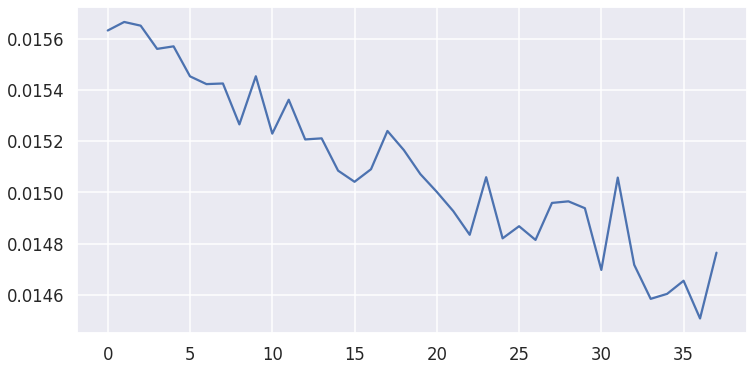

In [ ]:
sns.set(context="talk")
fig = plt.subplots(figsize=(12,6))
plt.plot(history.history['loss'])

学習曲線があまりよくないですね。こういう場合は<font color="red">callback</font>を使用するものです。

①学習している時にそれ以上精度の向上が見込めない場合に学習を途中で打ち切る。

②今まで重ねた学習の中から一番良いものを選択する。

In [ ]:
from keras import callbacks                   # コールバック（1epoch終了毎に呼び出される）
# モデルの学習
history = model.fit(
    X_train,
    y_train,
    batch_size=1,
    epochs=300, 
    validation_data=(X_test,y_test),        # コールバックする際はvalidation dataも準備する。
    callbacks=[
        callbacks.EarlyStopping(monitor='val_loss',patience=10),
        callbacks.ModelCheckpoint(filepath = './model/best_model.h5',monitor='', save_best_only=True)
        ]
)


Epoch 1/300
436/440 [============================>.] - ETA: 0s - loss: 0.0156

440/440 [==============================] - 6s 13ms/step - loss: 0.0156 - val_loss: 0.0282
Epoch 2/300
439/440 [============================>.] - ETA: 0s - loss: 0.0157

440/440 [==============================] - 6s 13ms/step - loss: 0.0157 - val_loss: 0.0259
Epoch 3/300
439/440 [============================>.] - ETA: 0s - loss: 0.0157

440/440 [==============================] - 9s 19ms/step - loss: 0.0157 - val_loss: 0.0257
Epoch 4/300
438/440 [============================>.] - ETA: 0s - loss: 0.0155

440/440 [==============================] - 6s 14ms/step - loss: 0.0156 - val_loss: 0.0265
Epoch 5/300
437/440 [============================>.] - ETA: 0s - loss: 0.0156

440/440 [==============================] - 6s 13ms/step - loss: 0.0156 - val_loss: 0.0259
Epoch 6/300
437/440 [============================>.] - ETA: 0s - loss: 0.0155

440/440 [==============================] - 6s 13ms/step - loss: 0.0155 - val_loss: 0.0251
Epoch 7/300
436/440 [============================>.] - ETA: 0s - loss: 0.0154

440/440 [==============================] - 6s 14ms/step - loss: 0.0154 - val_loss: 0.0283
Epoch 8/300
438/440 [============================>.] - ETA: 0s - loss: 0.0155

440/440 [==============================] - 6s 13ms/step - loss: 0.0154 - val_loss: 0.0261
Epoch 9/300
440/440 [==============================] - ETA: 0s - loss: 0.0153

440/440 [==============================] - 6s 13ms/step - loss: 0.0153 - val_loss: 0.0256
Epoch 10/300
440/440 [==============================] - ETA: 0s - loss: 0.0155

440/440 [==============================] - 6s 13ms/step - loss: 0.0155 - val_loss: 0.0268
Epoch 11/300
438/440 [============================>.] - ETA: 0s - loss: 0.0153

440/440 [==============================] - 6s 13ms/step - loss: 0.0152 - val_loss: 0.0247
Epoch 12/300
439/440 [============================>.] - ETA: 0s - loss: 0.0154

440/440 [==============================] - 6s 13ms/step - loss: 0.0154 - val_loss: 0.0282
Epoch 13/300
437/440 [============================>.] - ETA: 0s - loss: 0.0152

440/440 [==============================] - 6s 13ms/step - loss: 0.0152 - val_loss: 0.0293
Epoch 14/300
437/440 [============================>.] - ETA: 0s - loss: 0.0152

440/440 [==============================] - 6s 13ms/step - loss: 0.0152 - val_loss: 0.0278
Epoch 15/300
440/440 [==============================] - ETA: 0s - loss: 0.0151

440/440 [==============================] - 6s 13ms/step - loss: 0.0151 - val_loss: 0.0265
Epoch 16/300
439/440 [============================>.] - ETA: 0s - loss: 0.0151

440/440 [==============================] - 6s 13ms/step - loss: 0.0150 - val_loss: 0.0246
Epoch 17/300
440/440 [==============================] - ETA: 0s - loss: 0.0151

440/440 [==============================] - 6s 13ms/step - loss: 0.0151 - val_loss: 0.0267
Epoch 18/300
440/440 [==============================] - ETA: 0s - loss: 0.0152

440/440 [==============================] - 7s 15ms/step - loss: 0.0152 - val_loss: 0.0247
Epoch 19/300
439/440 [============================>.] - ETA: 0s - loss: 0.0150

440/440 [==============================] - 6s 13ms/step - loss: 0.0152 - val_loss: 0.0251
Epoch 20/300
437/440 [============================>.] - ETA: 0s - loss: 0.0151

440/440 [==============================] - 6s 13ms/step - loss: 0.0151 - val_loss: 0.0246
Epoch 21/300
439/440 [============================>.] - ETA: 0s - loss: 0.0150

440/440 [==============================] - 6s 14ms/step - loss: 0.0150 - val_loss: 0.0275
Epoch 22/300
439/440 [============================>.] - ETA: 0s - loss: 0.0149

440/440 [==============================] - 6s 13ms/step - loss: 0.0149 - val_loss: 0.0246
Epoch 23/300
437/440 [============================>.] - ETA: 0s - loss: 0.0149

440/440 [==============================] - 6s 13ms/step - loss: 0.0148 - val_loss: 0.0288
Epoch 24/300
436/440 [============================>.] - ETA: 0s - loss: 0.0151

440/440 [==============================] - 6s 13ms/step - loss: 0.0151 - val_loss: 0.0234
Epoch 25/300
440/440 [==============================] - ETA: 0s - loss: 0.0148

440/440 [==============================] - 6s 13ms/step - loss: 0.0148 - val_loss: 0.0271
Epoch 26/300
439/440 [============================>.] - ETA: 0s - loss: 0.0149

440/440 [==============================] - 6s 14ms/step - loss: 0.0149 - val_loss: 0.0283
Epoch 27/300
436/440 [============================>.] - ETA: 0s - loss: 0.0147

440/440 [==============================] - 6s 14ms/step - loss: 0.0148 - val_loss: 0.0300
Epoch 28/300
440/440 [==============================] - ETA: 0s - loss: 0.0150

440/440 [==============================] - 6s 14ms/step - loss: 0.0150 - val_loss: 0.0229
Epoch 29/300
438/440 [============================>.] - ETA: 0s - loss: 0.0150

440/440 [==============================] - 8s 18ms/step - loss: 0.0150 - val_loss: 0.0268
Epoch 30/300
439/440 [============================>.] - ETA: 0s - loss: 0.0149

440/440 [==============================] - 12s 27ms/step - loss: 0.0149 - val_loss: 0.0280
Epoch 31/300
440/440 [==============================] - ETA: 0s - loss: 0.0147

440/440 [==============================] - 6s 14ms/step - loss: 0.0147 - val_loss: 0.0284
Epoch 32/300
440/440 [==============================] - ETA: 0s - loss: 0.0151

440/440 [==============================] - 6s 13ms/step - loss: 0.0151 - val_loss: 0.0275
Epoch 33/300
436/440 [============================>.] - ETA: 0s - loss: 0.0148

440/440 [==============================] - 6s 13ms/step - loss: 0.0147 - val_loss: 0.0288
Epoch 34/300
438/440 [============================>.] - ETA: 0s - loss: 0.0146

440/440 [==============================] - 6s 13ms/step - loss: 0.0146 - val_loss: 0.0263
Epoch 35/300
438/440 [============================>.] - ETA: 0s - loss: 0.0146

440/440 [==============================] - 6s 13ms/step - loss: 0.0146 - val_loss: 0.0306
Epoch 36/300
439/440 [============================>.] - ETA: 0s - loss: 0.0147

440/440 [==============================] - 8s 17ms/step - loss: 0.0147 - val_loss: 0.0284
Epoch 37/300
437/440 [============================>.] - ETA: 0s - loss: 0.0146

440/440 [==============================] - 6s 14ms/step - loss: 0.0145 - val_loss: 0.0272
Epoch 38/300
440/440 [==============================] - ETA: 0s - loss: 0.0148

440/440 [==============================] - 6s 13ms/step - loss: 0.0148 - val_loss: 0.0275


In [ ]:
X_train
# X_test

array([[[0.1321499 , 0.        , 0.66506795],
        [0.18244576, 0.00807754, 0.63189448],
        [0.09467456, 0.02100162, 0.5059952 ],
        ...,
        [0.85009862, 0.12439418, 0.3057554 ],
        [0.87968442, 0.02100162, 0.38968825],
        [0.99704142, 0.00323102, 0.90047962]],

       [[0.18244576, 0.00807754, 0.63189448],
        [0.09467456, 0.02100162, 0.5059952 ],
        [0.22781065, 0.        , 0.54556355],
        ...,
        [0.87968442, 0.02100162, 0.38968825],
        [0.99704142, 0.00323102, 0.90047962],
        [0.92751479, 0.0371567 , 0.46402878]],

       [[0.09467456, 0.02100162, 0.5059952 ],
        [0.22781065, 0.        , 0.54556355],
        [0.24112426, 0.        , 0.5647482 ],
        ...,
        [0.99704142, 0.00323102, 0.90047962],
        [0.92751479, 0.0371567 , 0.46402878],
        [0.95808679, 0.        , 0.65107914]],

       ...,

       [[0.6913215 , 0.        , 0.73381295],
        [0.65927022, 0.04846527, 0.63908873],
        [0.68491124, 0

### 予測

　黒が本物の線。
　青が学習済みの予測した線、
　赤が見学習の予測済みの線、
　緑が未来予測の線

1/1 [==============================] - 0s 37ms/step


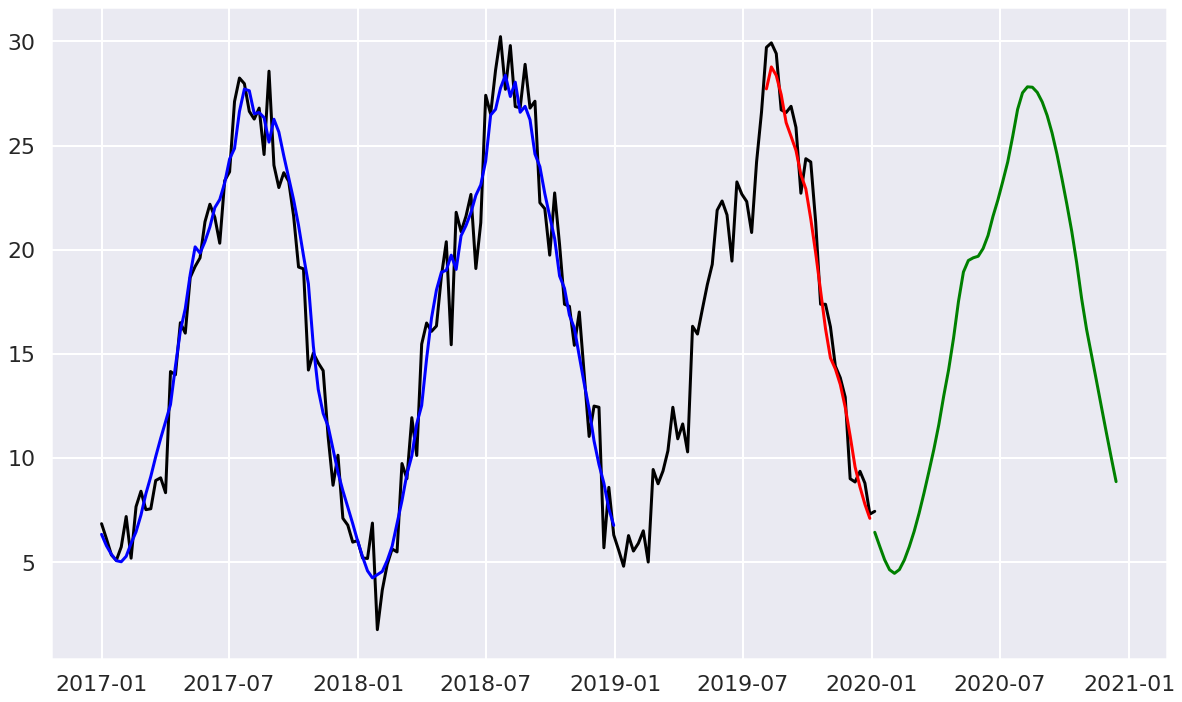

In [ ]:
sns.set(context="poster",font="Hiragino Maru Gothic Pro")
fig = plt.subplots(figsize=(20,12))

#正解のプロット
df_week = pd.DataFrame(scaler.inverse_transform(df_week_scale),
                       index=df_week.index,columns=df_week.columns)
plt.plot(df_week["2017":]["平均気温(℃)"],color="black")

#学習用データ予測結果のプロット
df_week_train_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_train)),
                                  index=df_week_scale_train.index[look_back:],columns=df_week_scale_train.columns)
plt.plot(df_week_train_pred["2017":]["平均気温(℃)"],color="blue")

#評価用データ予測結果のプロット
df_week_test_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_test)),
                                 index=df_week_scale_test.index[look_back:],columns=df_week_scale_test.columns)
plt.plot(df_week_test_pred["2017":]["平均気温(℃)"],color="red")

#未来予測
future_steps = 50
X_future = [df_week_scale_test[-look_back:].values.tolist()]
y_future_list = []

for step in range(future_steps):
    y_future = model.predict(X_future)
    y_future_list.append(y_future[0])
    X_future = [X_future[0][1:] + y_future.tolist()]
    
df_week_future = pd.DataFrame(scaler.inverse_transform(y_future_list),
                              index=pd.date_range('2020-01-01', periods=future_steps, freq='W'),columns=df_week.columns)
plt.plot(df_week_future["2017":]["平均気温(℃)"],color="green")

そして「降水量の予測」も行ってみますか。⇒実際は上手く行きませんでした。そういうものです。

1/1 [==============================] - 0s 32ms/step


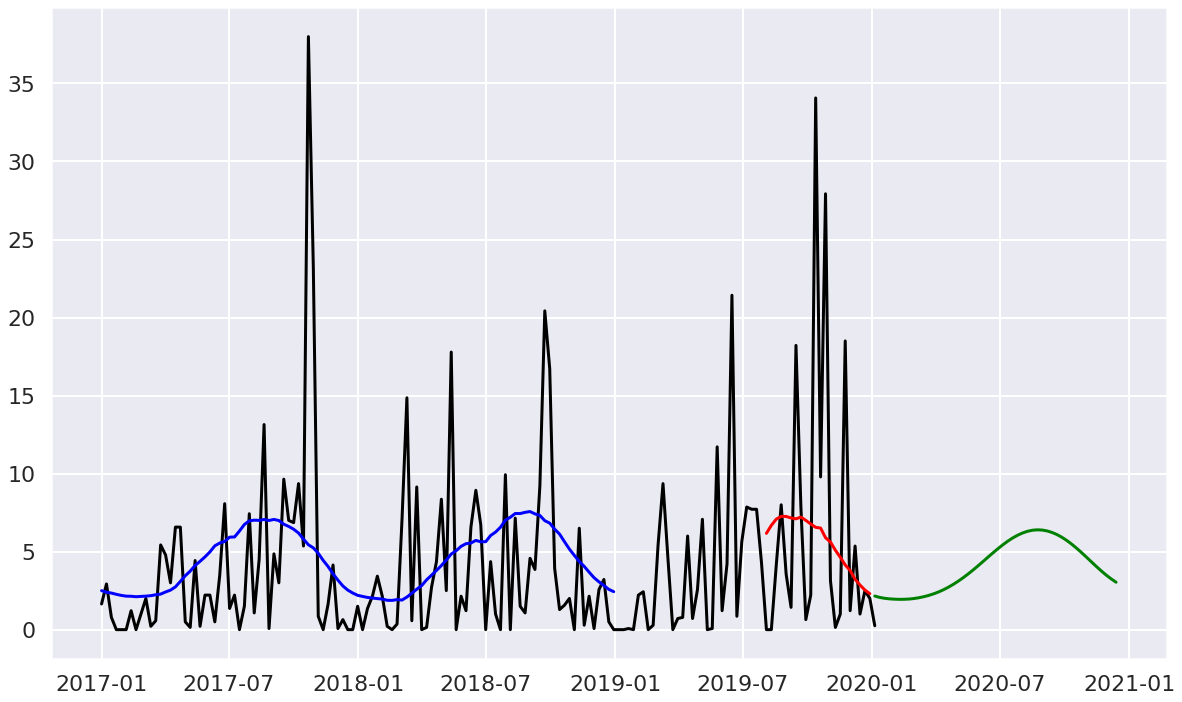

In [ ]:
sns.set(context="poster",font="Hiragino Maru Gothic Pro")
fig = plt.subplots(figsize=(20,12))

#正解のプロット
df_week = pd.DataFrame(scaler.inverse_transform(df_week_scale),
                       index=df_week.index,columns=df_week.columns)
plt.plot(df_week["2017":]["降水量の合計(mm)"],color="black")

#学習用データ予測結果のプロット
df_week_train_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_train)),
                                  index=df_week_scale_train.index[look_back:],columns=df_week_scale_train.columns)
plt.plot(df_week_train_pred["2017":]["降水量の合計(mm)"],color="blue")

#評価用データ予測結果のプロット
df_week_test_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_test)),
                                 index=df_week_scale_test.index[look_back:],columns=df_week_scale_test.columns)
plt.plot(df_week_test_pred["2017":]["降水量の合計(mm)"],color="red")

#未来予測
future_steps = 50
X_future = [df_week_scale_test[-look_back:].values.tolist()]
y_future_list = []

for step in range(future_steps):
    y_future = model.predict(X_future)
    y_future_list.append(y_future[0])
    X_future = [X_future[0][1:] + y_future.tolist()]
    
df_week_future = pd.DataFrame(scaler.inverse_transform(y_future_list),
                              index=pd.date_range('2020-01-01', periods=future_steps, freq='W'),columns=df_week.columns)
plt.plot(df_week_future["2017":]["降水量の合計(mm)"],color="green")

そして上手く行かなかったら、ニューラルネットワークの色々な変数をいじってみましょう。

### rmse算出

面倒ですが、ここまで来たらrmse算出しますか。

In [ ]:
df_week.head(10)

,平均気温(℃),降水量の合計(mm),日照時間(時間)
年月日,,,
2010-01-03,5.600000,0.000000,8.266667
2010-01-10,7.057143,0.357143,7.871429
2010-01-17,4.514286,0.928571,6.371429
2010-01-24,8.371429,0.000000,6.842857
2010-01-31,8.757143,0.000000,7.071429
2010-02-07,4.242857,4.785714,6.500000
2010-02-14,5.914286,1.785714,3.085714
2010-02-21,4.942857,2.785714,2.871429
2010-02-28,10.900000,7.071429,4.442857


rmse用のデータを作成します。今回は"2019-09-01" <= 年月日 < "2019-12-29"までで。

In [ ]:
# 何行目から何行目までとかじゃない。datetimeで、2019-09-01から2019-12-29まで。
#これは予測値
df_week_test_pred2 = df_week_test_pred.query('"2019-09-01" <= 年月日 < "2019-12-29"')
df_week_test_pred2

,平均気温(℃),降水量の合計(mm),日照時間(時間)
年月日,,,
2019-09-01,26.105154,5.650876,5.213512
2019-09-08,25.445349,7.090033,4.948630
2019-09-15,24.766977,8.631776,4.898962
2019-09-22,23.604704,9.566956,4.492909
2019-09-29,22.923855,9.796398,4.492729
2019-10-06,21.487631,10.278147,4.397624
2019-10-13,19.845011,8.896468,4.335024
2019-10-20,18.027832,5.870172,4.365109
2019-10-27,16.210098,3.541753,4.896089


In [ ]:
#これは実測値
df_week_test = df_week.query('"2019-09-01" <= 年月日 < "2019-12-29"')
df_week_test

,平均気温(℃),降水量の合計(mm),日照時間(時間)
年月日,,,
2019-09-01,26.585714,3.571429,2.571429
2019-09-08,26.885714,1.428571,3.928571
2019-09-15,25.871429,18.214286,4.528571
2019-09-22,22.714286,7.857143,4.642857
2019-09-29,24.371429,0.642857,5.528571
2019-10-06,24.214286,2.214286,5.914286
2019-10-13,21.328571,34.071429,4.371429
2019-10-20,17.385714,9.785714,0.600000
2019-10-27,17.385714,27.928571,2.771429


rmse算出

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error as MSE
# y_trainと予測値のRMSEを出す
print("RMSE",np.sqrt(MSE(df_week_test["平均気温(℃)"],df_week_test_pred2["平均気温(℃)"])))

RMSE 1.2548071579097844
